In [58]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

import jax
from jax import jit
from jax.lib import xla_bridge
print(f"Jax is using: {xla_bridge.get_backend().platform}")

import sys
sys.path.append('../')

Jax is using: gpu


# Simulate data

In [60]:
# define linear ultrasound transducer (P4-1)
nelements = 64
element_pitch = 2.95e-4 # distance between transducer elements
transducer_extent = (nelements - 1) * element_pitch # length of the transducer [m]
transducer_frequency = 1e6 # frequency of the transducer [Hz]
transducer_magnitude = 1e6 # magnitude of the transducer [Pa]
print(f"Transducer extent: {transducer_extent:.3f} m")

Transducer extent: 0.019 m


In [61]:
# define spatial parameters
N = np.array([128, 128]).astype(int) # grid size [grid points]
dx = np.array([element_pitch, element_pitch]) # grid spacing [m]
pml = np.array([20, 20]) # size of the perfectly matched layer [grid points]

# define transducer position in domain
transducer_depth = pml[1] # depth of the transducer [grid points]
transducer_x_start = N[0]//2 - nelements//2 # start index of the transducer in the x-direction [grid points]
element_positions = np.array([
    np.linspace(transducer_x_start, transducer_x_start + nelements - 1, nelements),
    (N[1] - transducer_depth) * np.ones(nelements),
], dtype=int)

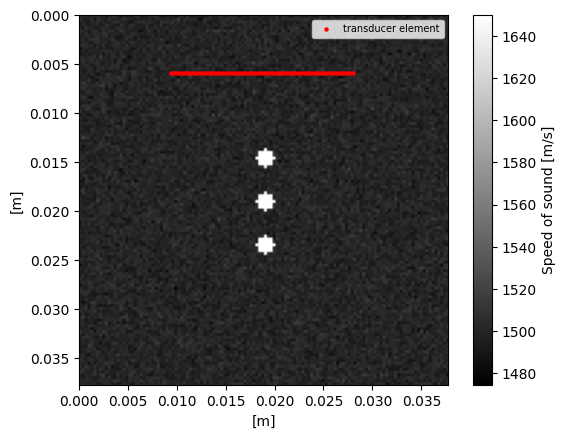

In [62]:
from jwave_utils import get_domain, get_point_medium, get_homogeneous_medium

# define jwave medium
medium_params = {
    'c0': 1500,  # speed of sound [m/s]
    'rho0': 1000,  # density [kg/m^3]
    'background_mean': 1,  # mean of the background noise
    'pml_size': pml[0]  # size of the perfectly matched layer [grid points]
}

domain = get_domain(N, dx)
speed_homogenous, density_homogenous = get_homogeneous_medium(domain, **medium_params, background_std=0, background_seed=29)

scatterer_positions = np.array([[domain.N[0]//2, domain.N[1]//2 + 15],
                                [domain.N[0]//2, domain.N[1]//2],
                                [domain.N[0]//2, domain.N[1]//2 - 15]], dtype=int)
speed, density = get_point_medium(domain, scatterer_positions, **medium_params, background_std = 0.004, scatterer_radius=3, scatterer_contrast=1.1, background_seed=28)

ext = [0, N[0]*dx[0], N[1]*dx[1], 0]
plt.scatter(element_positions[0]*dx[0], N[1]*dx[1] - element_positions[1]*dx[1],
            c='r', marker='o', s=5, label='transducer element')
plt.imshow(np.rot90(speed), cmap='gray', extent=[0, N[1]*dx[1], 0, N[0]*dx[0]])
plt.colorbar(label='Speed of sound [m/s]')
plt.ylabel('[m]')
plt.xlabel('[m]')
plt.legend(prop={'size': 7})
plt.gca().invert_yaxis()
plt.show()

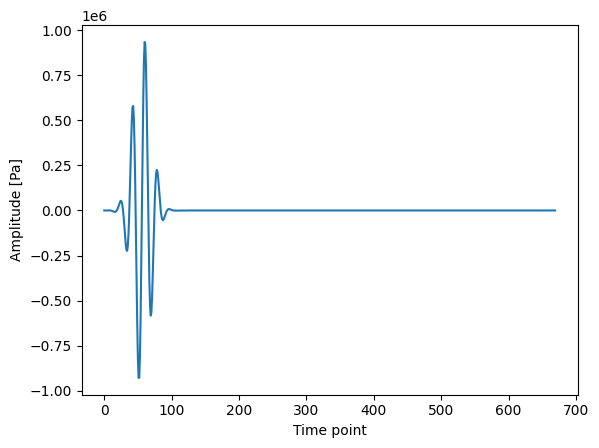

In [63]:
from jwave.geometry import TimeAxis
from jwave.geometry import Medium
from jwave_utils import get_plane_wave_excitation

signal_delay = 0
time_axis = TimeAxis.from_medium(Medium(domain, speed, density, pml_size=pml[0]), cfl=0.3)
sources, signal, carrier_signal = get_plane_wave_excitation(domain, time_axis, transducer_magnitude, transducer_frequency, element_positions, signal_delay=signal_delay)

plt.plot(sources.signals[0])
plt.xlabel('Time point')
plt.ylabel('Amplitude [Pa]')
plt.show()

In [64]:
from jwave_utils import get_data

# simulate data using jwave
pressure, data = get_data(speed, density, domain, time_axis, sources, element_positions)
_, data_homogenous = get_data(speed_homogenous, density_homogenous, domain, time_axis, sources, element_positions)

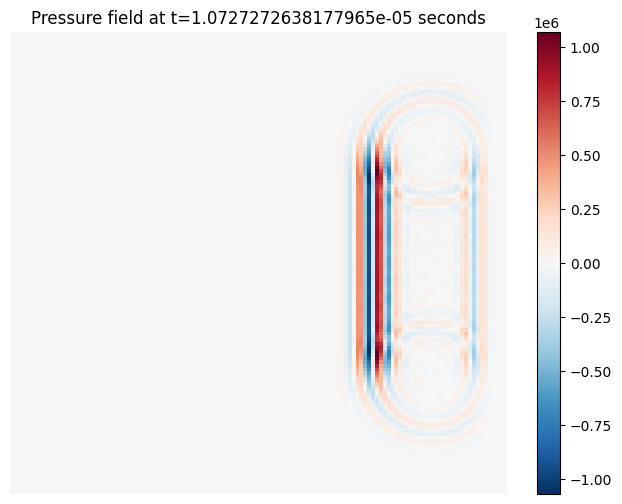

In [65]:
from jwave.utils import show_field

t_idx = 200
show_field(pressure[110])
plt.title(f"Pressure field at t={time_axis.to_array()[t_idx]} seconds")
plt.show()

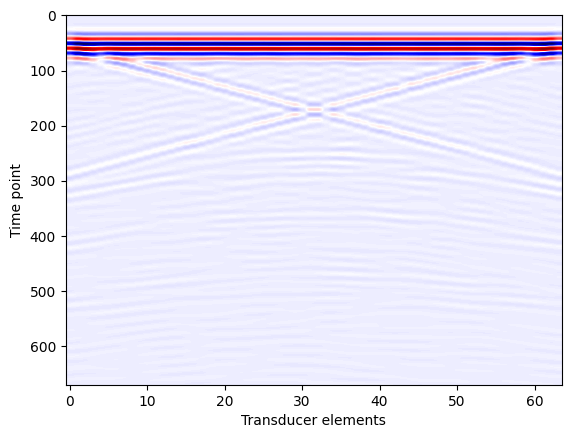

In [66]:
plt.imshow(data, aspect='auto', cmap='seismic')
plt.xlabel('Transducer elements')
plt.ylabel('Time point')
plt.show()

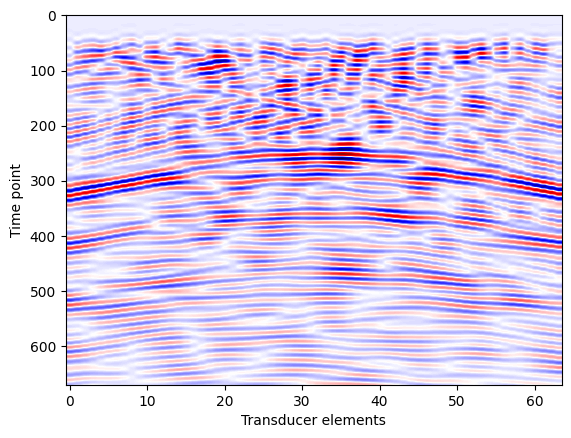

In [67]:
output_data = data-data_homogenous
plt.imshow(output_data, aspect='auto', cmap='seismic')
plt.xlabel('Transducer elements')
plt.ylabel('Time point')
plt.show()

## NTK Beamforming

In [68]:
# get_receive_beamforming(domain, time_axis, element_positions, output_data, signal, carrier_signal, signal_delay)
1/time_axis.dt/1e6

18.644067796610173

In [69]:
from imaging.demodulate import demodulate_rf_to_iq
freq_sampling = 1/time_axis.dt
iq_signals, freq_carrier = demodulate_rf_to_iq(output_data, freq_sampling, freq_carrier=transducer_frequency)

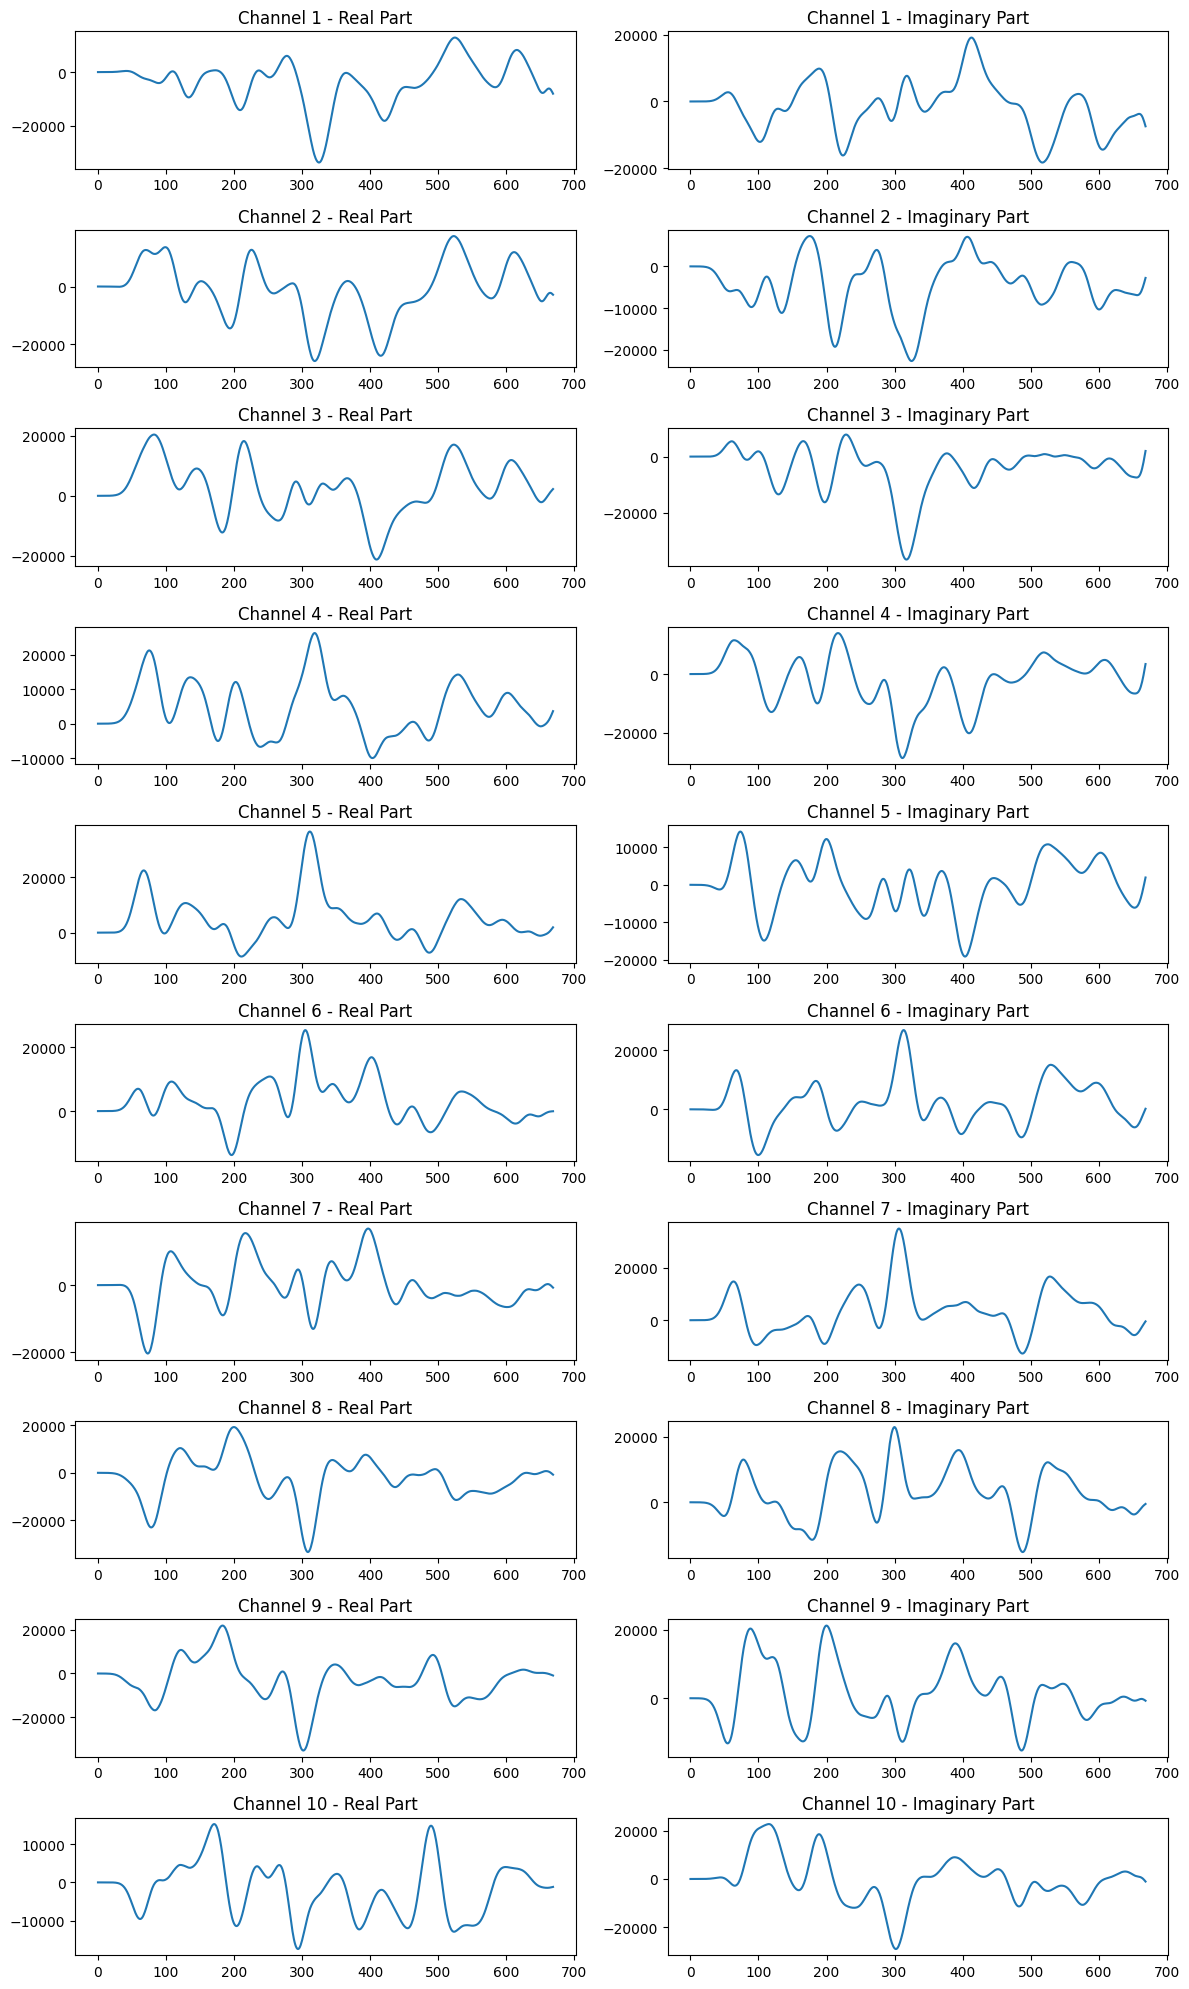

In [70]:
fig, axs = plt.subplots(10, 2, figsize=(12, 20))

for i in range(10):
    axs[i, 0].plot(np.real(iq_signals[:, i]))
    axs[i, 0].set_title(f"Channel {i+1} - Real Part")
    axs[i, 1].plot(np.imag(iq_signals[:, i]))
    axs[i, 1].set_title(f"Channel {i+1} - Imaginary Part")

plt.tight_layout()
plt.show()

In [71]:
N = domain.N[0]
Nz = N - transducer_depth
dx0 = domain.dx[0]

# Generate 1D arrays for x and z
x = np.linspace(-(N//2)*dx0, (N//2)*dx0, N)
z = np.linspace(0, Nz*dx0, Nz)

# Create 2D meshgrid for x and z
X, Z = np.meshgrid(x, z)

In [72]:
from imaging.beamform import beamform_delay_and_sum

beamformed_signal = beamform_delay_and_sum(iq_signals, X, Z, freq_sampling, freq_carrier, pitch=dx0, tx_delays=np.zeros(nelements))

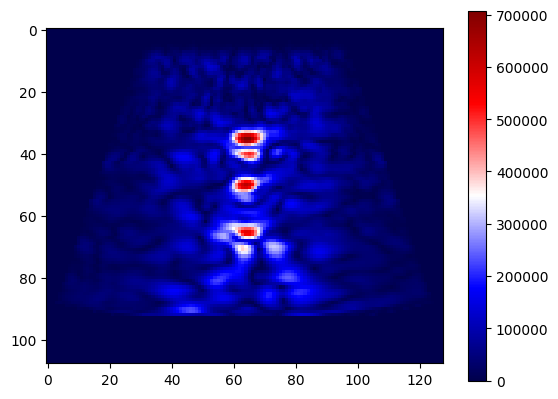

In [73]:
beamformed_signal_2 = beamformed_signal.copy()
# beamformed_signal_2[:25, :] = 0

plt.imshow(np.abs(beamformed_signal_2), cmap='seismic')
plt.colorbar()
plt.show()


# Reconstruction

## Single angle

In [74]:
from beamforming_utils import get_receive_beamforming
res = get_receive_beamforming(domain, time_axis, element_positions, output_data, signal, carrier_signal, signal_delay)

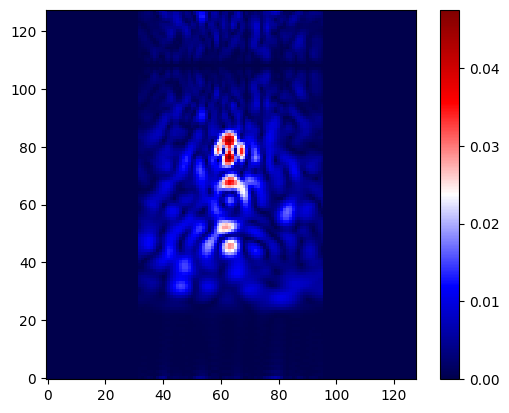

In [75]:
from kwave.utils.filters import gaussian_filter
from kwave.reconstruction.beamform import envelope_detection

def postprocess_result(orig_res):
    result = np.copy(orig_res)
    for i in range(result.shape[0]):
        result[i, :] = gaussian_filter(result[i, :], 1/dx[0], transducer_frequency, 100.0)
    for i in range(result.shape[0]):
        result[i, :] = envelope_detection(result[i, :])
    return np.flipud(result).T

bmode=postprocess_result(res)
plt.imshow(bmode, cmap='seismic', interpolation='nearest')
plt.colorbar()
plt.gca().invert_yaxis()
plt.show()

## Multiple angles

In [76]:
signal_delays = np.linspace(-5, 5, 10)
results = []
for signal_delay in signal_delays:
    print(f"Signal delay: {signal_delay}")
    sources, signal, carrier_signal = get_plane_wave_excitation(domain, time_axis, transducer_magnitude, transducer_frequency, element_positions, signal_delay=signal_delay)
    _, data = get_data(speed, density, domain, time_axis, sources, element_positions)
    _, data_homogenous = get_data(speed_homogenous, density_homogenous, domain, time_axis, sources, element_positions)
    output_data = data-data_homogenous
    res = get_receive_beamforming(domain, time_axis, element_positions, data, signal, carrier_signal, signal_delay)
    results.append(res)

Signal delay: -5.0


Signal delay: -3.888888888888889
Signal delay: -2.7777777777777777
Signal delay: -1.6666666666666665
Signal delay: -0.5555555555555554
Signal delay: 0.5555555555555554
Signal delay: 1.666666666666667
Signal delay: 2.7777777777777786
Signal delay: 3.8888888888888893
Signal delay: 5.0


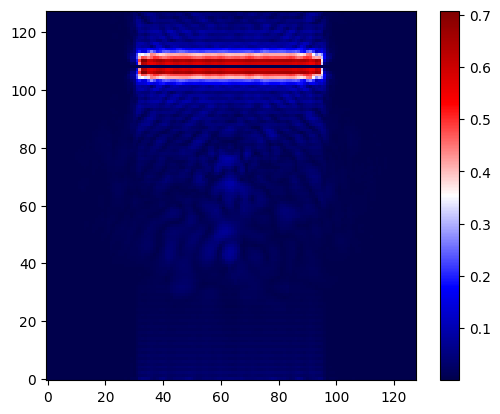

In [77]:
compounded_res = np.sum(results, axis=0)
compounded_bmode=postprocess_result(compounded_res)
# bmodes = [postprocess_result(res) for res in results]
# compounded_bmode = np.sum(bmodes, axis=0)

plt.imshow(compounded_bmode, cmap='seismic', interpolation='nearest')
plt.colorbar()
plt.gca().invert_yaxis()
plt.show()

## Gradient

In [78]:
from jax import value_and_grad
from jwave_utils import get_data_only

ntimepoints, nelements = output_data.shape
params = speed

@jit
def linear_loss(speed, J, dy):
    loss = jnp.linalg.norm(dy - (J @ (speed - speed_homogenous).flatten()).reshape((ntimepoints, nelements)), ord='fro')
    return loss
# @jit
# def linear_loss(x, A, b):
#     Ax = jnp.tensordot(A, x, axes=([0, 1, 2], [0, 1, 2]))
#     return jnp.sum((Ax - b) ** 2)
linear_val_and_grad = value_and_grad(linear_loss, argnums=0)

@jit
def nonlinear_loss(speed):
    predicted = get_data_only(speed, density_homogenous, domain, time_axis, sources, element_positions)
    observed = data_homogenous
    loss = jnp.linalg.norm(observed - predicted, ord='fro')
    return loss
nonlinear_val_and_grad = value_and_grad(nonlinear_loss, argnums=0)

In [79]:
# compute first linear gradient
J = jax.jacrev(get_data_only, argnums=0)(jnp.array(speed), density_homogenous, domain, time_axis, sources, element_positions)
linear_loss, linear_gradient = linear_val_and_grad(params, J, output_data)
print(f"Linear loss: {linear_loss}")

2024-08-11 23:48:21.219138: W external/xla/xla/tsl/framework/bfc_allocator.cc:482] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.85GiB (rounded to 7354777600)requested by op 
2024-08-11 23:48:21.220225: W external/xla/xla/tsl/framework/bfc_allocator.cc:494] *************************************************************_______________________________________
E0811 23:48:21.220277   62267 pjrt_stream_executor_client.cc:2985] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 7354777600 bytes.


KeyboardInterrupt: 

In [ ]:
# compute first nonlinear gradient
nonlinear_loss, nonlinear_gradient = nonlinear_val_and_grad(params)
print(f"Nonlinear loss: {nonlinear_loss}")

Nonlinear loss: 1074841.5


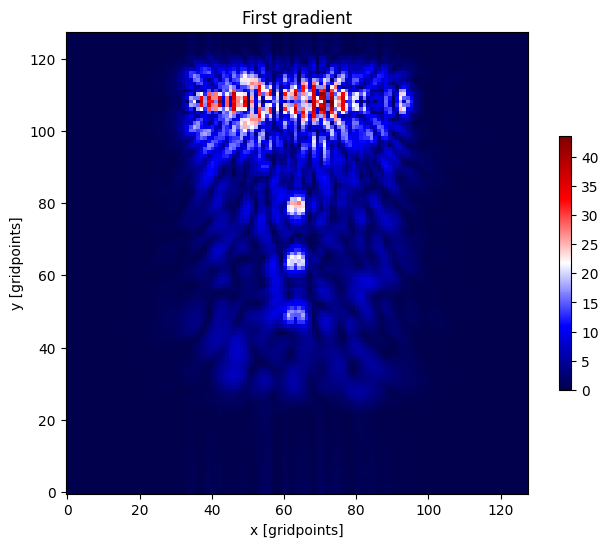

In [ ]:
# Viualize
plt.figure(figsize=(8, 6))
plt.imshow(postprocess_result(nonlinear_gradient), cmap='seismic')
plt.title("First gradient")
plt.xlabel('x [gridpoints]')
plt.ylabel('y [gridpoints]')
plt.gca().invert_yaxis()
plt.colorbar(shrink=0.55)
plt.show()